# Prediction models

## Importing libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utility_functions import my_confusion_matrix, my_classification_scores, my_dataframe_split

In [3]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.metrics import roc_curve, auc

In [4]:
import statsmodels.api as sm
import xgboost as xgb

In [5]:
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization
from tensorflow.keras.metrics import AUC

## Data preprocessing

In [6]:
# Load the dataset
insurance_train_path = 'data/train.csv'
insurance_train_raw_df = pd.read_csv(insurance_train_path,index_col=None)
insurance_train_raw_df.columns= insurance_train_raw_df.columns.str.lower()
insurance_train_raw_df.columns = insurance_train_raw_df.columns.str.replace(' ','_')
insurance_train_df = insurance_train_raw_df.copy()

In [7]:
# Data processing

# Vehicle Damage: Map 'Yes' to 1 and 'No' to 0
insurance_train_df['vehicle_damage'] = insurance_train_df['vehicle_damage'].map({'Yes': 1, 'No': 0})

# Gender: Map 'Female' to 1 and 'Male' to 0
insurance_train_df['gender'] = insurance_train_df['gender'].map({'Female': 1, 'Male': 0})

# Vehicle Age: Map '< 1 Year' to 0,'1-2 Year' to 1 and '> 2 Years' to 2
insurance_train_df['vehicle_age'] = insurance_train_df['vehicle_age'].map({'< 1 Year': 0, '1-2 Year': 1,'> 2 Years': 2,})

In [8]:
# Int Type for policy_sales_channel and region_code
insurance_train_df['policy_sales_channel'] = insurance_train_df['policy_sales_channel'].astype(int)
insurance_train_df['region_code'] = insurance_train_df['region_code'].astype(int)

# Sorting and identifying quartiles for region considering the response
region_response_proportion = insurance_train_df.groupby('region_code')['response'].mean().reset_index()
region_response_proportion = region_response_proportion.sort_values(by='response')
region_response_proportion['region_quartile'] = pd.qcut(region_response_proportion['response'], 4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
region_response_proportion

# Sorting and identifying quartiles for region considering the response
channel_response_proportion = insurance_train_df.groupby('policy_sales_channel')['response'].mean().reset_index()
channel_response_proportion = channel_response_proportion.sort_values(by='response')
channel_response_proportion['channel_sextile'] = pd.qcut(channel_response_proportion['response'], 6, labels=['G1', 'G2', 'G3', 'G4','G5','G6'])

#Incorporating the calculated region quartiles in the dataframe
insurance_train_df = insurance_train_df.merge(
    region_response_proportion[['region_code', 'region_quartile']], 
    on='region_code', 
    how='left'
)
#Incorporating the calculated channel sextiles in the dataframe
insurance_train_df = insurance_train_df.merge(
    channel_response_proportion[['policy_sales_channel', 'channel_sextile']], 
    on='policy_sales_channel', 
    how='left'
)

In [9]:
# One hot encoding
insurance_train_df = pd.get_dummies(insurance_train_df, columns=['region_quartile', 'channel_sextile'])

# Formating the dummies as 1s and 0s instead of True and False
boolean_columns = insurance_train_df.select_dtypes(include='bool').columns
insurance_train_df[boolean_columns] = insurance_train_df[boolean_columns].astype(int)

#dropping unnecesary columns
insurance_train_df = insurance_train_df.drop(columns=['region_code', 'policy_sales_channel'])

In [10]:
# View of the data
insurance_train_df

,id,gender,age,driving_license,previously_insured,vehicle_age,vehicle_damage,annual_premium,vintage,response,region_quartile_Q1,region_quartile_Q2,region_quartile_Q3,region_quartile_Q4,channel_sextile_G1,channel_sextile_G2,channel_sextile_G3,channel_sextile_G4,channel_sextile_G5,channel_sextile_G6
0,0,0,21,1,0,1,1,65101.0,187,0,0,0,0,1,0,0,0,0,1,0
1,1,0,43,1,0,2,1,58911.0,288,1,0,0,0,1,0,0,0,0,1,0
2,2,1,25,1,1,0,0,38043.0,254,0,0,1,0,0,1,0,0,0,0,0
3,3,1,35,1,0,1,1,2630.0,76,0,0,0,1,0,0,0,0,0,1,0
4,4,1,36,1,1,1,0,31951.0,294,0,1,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11504793,11504793,0,48,1,0,1,1,27412.0,218,0,1,0,0,0,0,0,0,0,1,0
11504794,11504794,1,26,1,0,0,1,29509.0,115,1,0,1,0,0,1,0,0,0,0,0
11504795,11504795,1,29,1,1,0,0,2630.0,189,0,0,1,0,0,1,0,0,0,0,0
11504796,11504796,1,51,1,0,1,1,48443.0,274,1,0,0,0,1,0,0,0,0,1,0


In [11]:
# Sampling the data, the dataset. Using a sample for doing tests. Sample of 10%
#insurance_train_df = insurance_train_df.sample(frac=0.1, random_state=42).reset_index(drop=True)

In [12]:
insurance_train_df.columns

Index(['id', 'gender', 'age', 'driving_license', 'previously_insured',
       'vehicle_age', 'vehicle_damage', 'annual_premium', 'vintage',
       'response', 'region_quartile_Q1', 'region_quartile_Q2',
       'region_quartile_Q3', 'region_quartile_Q4', 'channel_sextile_G1',
       'channel_sextile_G2', 'channel_sextile_G3', 'channel_sextile_G4',
       'channel_sextile_G5', 'channel_sextile_G6'],
      dtype='object')

In [13]:
train_df, validation_df, test_df = my_dataframe_split(insurance_train_df,0.7,0.15,0.15)

In [14]:
print("train_df size: ",len(train_df))
print("validation_df size: ",len(validation_df))
print("test_df size: ",len(test_df))

train_df size:  8053359
validation_df size:  1725720
test_df size:  1725719


In [15]:
explanatory_variables = list(train_df.columns)
explanatory_variables.remove('id')
explanatory_variables.remove('response')
print("number of explanatory variables: ", len(explanatory_variables))
explanatory_variables

number of explanatory variables:  18


['gender',
 'age',
 'driving_license',
 'previously_insured',
 'vehicle_age',
 'vehicle_damage',
 'annual_premium',
 'vintage',
 'region_quartile_Q1',
 'region_quartile_Q2',
 'region_quartile_Q3',
 'region_quartile_Q4',
 'channel_sextile_G1',
 'channel_sextile_G2',
 'channel_sextile_G3',
 'channel_sextile_G4',
 'channel_sextile_G5',
 'channel_sextile_G6']

## Logistic Regression

In [15]:
# Relevant variables for the logistic regression
# relevant_variables = ['gender', 'age', 'driving_license', 'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium', 'vintage']

In [16]:
x_train = train_df[explanatory_variables]
y_train = train_df['response']

x_validation = validation_df[explanatory_variables]
y_validation = validation_df['response']

x_test = test_df[explanatory_variables]
y_test = test_df['response']

In [17]:
# building the model and fitting the data
log_reg = sm.Logit(y_train, x_train).fit()
log_reg.summary()

Optimization terminated successfully.
         Current function value: 0.268320
         Iterations 11


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               response   No. Observations:              8053359
Model:                          Logit   Df Residuals:                  8053341
Method:                           MLE   Df Model:                           17
Date:                Fri, 26 Jul 2024   Pseudo R-squ.:                  0.2809
Time:                        11:44:50   Log-Likelihood:            -2.1609e+06
converged:                       True   LL-Null:                   -3.0049e+06
Covariance Type:            nonrobust   LLR p-value:                     0.000
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
gender                -0.0709      0.002    -28.888      0.000      -0.076      -0.066
age                   -0.0268      0.000   -220.145      0.000      -0.027      -0.027
driving_license        1.0092      0.035     28.747      0.000       0.940       1.078
previously_insured    -4.1288      0.021   -195.468      0.000      -4.170      -4.087
vehicle_age            0.2734      0.003     83.997      0.000       0.267       0.280
vehicle_damage         2.0470      0.008    249.661      0.000       2.031       2.063
annual_premium      3.761e-06   7.22e-08     52.076      0.000    3.62e-06     3.9e-06
vintage               -0.0003   1.49e-05    -19.572      0.000      -0.000      -0.000
region_quartile_Q1    -2.3083    1.1e+04     -0.000      1.000   -2.15e+04    2.15e+04
region_quartile_Q2    -2.3662    1.1e+04     -0.000      1.000   -2.15e+04    2.15e+04
region_quartile_Q3    -2.0771    1.1e+04     -0.000      1.000   -2.15e+04    2.15e+04
region_quartile_Q4    -2.0638    1.1e+04     -0.000      1.000   -2.15e+04    2.15e+04
channel_sextile_G1    -2.3083    1.1e+04     -0.000      1.000   -2.15e+04    2.15e+04
channel_sextile_G2    -2.1707    1.1e+04     -0.000      1.000   -2.15e+04    2.15e+04
channel_sextile_G3    -1.4320    1.1e+04     -0.000      1.000   -2.15e+04    2.15e+04
channel_sextile_G4    -1.2129    1.1e+04     -0.000      1.000   -2.15e+04    2.15e+04
channel_sextile_G5    -0.8933    1.1e+04  -8.15e-05      1.000   -2.15e+04    2.15e+04
channel_sextile_G6    -0.7982    1.1e+04  -7.29e-05      1.000   -2.15e+04    2.15e+04
======================================================================================
"""

In [18]:
# performing predictions on the test dataset
y_hat = log_reg.predict(x_test)
y_prediction = y_hat

In [19]:
# when the prediction has to be either 1 or 0, no in between. This is needed for calculating the metrics of the confusion matrix
y_prediction = list(map(round, y_hat))
tp,fp,fn,tn = my_confusion_matrix(y_test,y_prediction)
tp,fp,fn,tn

(76, 237, 211281, 1514125)

In [20]:
my_classification_scores(tp,fp,fn,tn)

{'accuracy': 0.8774319573464742,
 'sensitivity': 0.00035958118254895743,
 'specificity': 0.9998434984501724,
 'precision': 0.24281150159744408,
 'f1_score': 0.0007180989275759437}

In [21]:
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_hat)

# Calculate the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)
roc_auc

0.8499634999076363

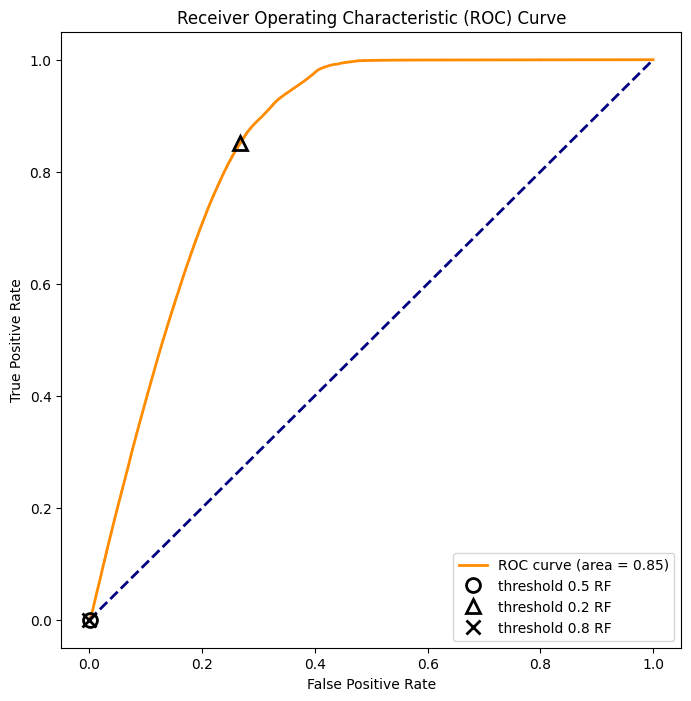

In [22]:
# Plot the ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

close_default_rf = np.argmin(np.abs(thresholds - 0.5))
plt.plot(fpr[close_default_rf], tpr[close_default_rf], 'o', markersize=10,label="threshold 0.5 RF", fillstyle="none", c='k', mew=2)

close_default_rf = np.argmin(np.abs(thresholds - 0.2))
plt.plot(fpr[close_default_rf], tpr[close_default_rf], '^', markersize=10,label="threshold 0.2 RF", fillstyle="none", c='k', mew=2)

close_default_rf = np.argmin(np.abs(thresholds - 0.8))
plt.plot(fpr[close_default_rf], tpr[close_default_rf], 'x', markersize=10,label="threshold 0.8 RF", fillstyle="none", c='k', mew=2)


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


## Neural Networks

### Data Sampling

In [16]:
#training of the neural network takes to long for my computer, will work with a sample
sample_df = insurance_train_df.sample(frac=0.1, random_state=42).reset_index(drop=True)
train_df, validation_df, test_df = my_dataframe_split(sample_df,0.7,0.15,0.15)

In [17]:
len(explanatory_variables)

18

In [18]:
x_train = train_df[explanatory_variables]
y_train = train_df['response']

x_validation = validation_df[explanatory_variables]
y_validation = validation_df['response']

x_test = test_df[explanatory_variables]
y_test = test_df['response']

### Neural Network Training

In [19]:
#### Current best Architecture
early_stopping = keras.callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=30, # how many epochs to wait before stopping
    restore_best_weights=True,
)

# Initialize the model
nn_model = Sequential()

# Add layers
nn_model.add(Input(shape=(18,)))  # Input layer
nn_model.add(BatchNormalization())
nn_model.add(Dense(512, activation='relu'))
nn_model.add(Dropout(0.2))
nn_model.add(Dense(256, activation='relu'))
nn_model.add(Dense(1, activation='sigmoid'))  # Output layer

#nn_model.add(Input(shape=(18,)))  # Input layer
#nn_model.add(BatchNormalization())
#nn_model.add(Dense(256, activation='relu'))
#nn_model.add(Dropout(0.2))
#nn_model.add(Dense(128, activation='relu'))
#nn_model.add(Dense(1, activation='sigmoid'))  # Output layer

# Compile the model with binary_crossentropy loss and AUC as a metric
nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[AUC(name='auc')])

In [20]:
history = nn_model.fit(
    x_train, y_train,
    validation_data=(x_validation, y_validation),
    batch_size=512,
    epochs=200,
    callbacks=[early_stopping]
)

Epoch 1/200
1573/1573 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - auc: 0.8417 - loss: 0.2743 - val_auc: 0.8563 - val_loss: 0.2659
Epoch 2/200
1573/1573 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - auc: 0.8556 - loss: 0.2652 - val_auc: 0.8571 - val_loss: 0.2658
Epoch 3/200
1573/1573 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - auc: 0.8572 - loss: 0.2641 - val_auc: 0.8577 - val_loss: 0.2655
Epoch 4/200
1573/1573 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - auc: 0.8577 - loss: 0.2639 - val_auc: 0.8571 - val_loss: 0.2657
Epoch 5/200
1573/1573 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - auc: 0.8580 - loss: 0.2629 - val_auc: 0.8574 - val_loss: 0.2656
Epoch 6/200
1573/1573 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - auc: 0.8588 - loss: 0.2643 - val_auc: 0.8581 - val_loss: 0.2654
Epoch 7/200
1573/1573 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - auc: 0.8583 - loss: 0.2629 - val_auc: 0.8585 - val_loss: 0.2650
Epoch 8/200
1573/1573 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - auc: 0.8580 - loss: 0.2642 - val_auc: 0.8582 - val_loss: 0.2653
Epoch 9/200
1573/1573 ━

In [21]:
nn_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ batch_normalization                  │ (None, 18)                  │              72 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │           9,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 424,085 (1.62 MB)

 Trainable params: 141,349 (552.14 KB)

 Non-trainable params: 36 (144.00 B)

 Optimizer params: 282,700 (1.08 MB)

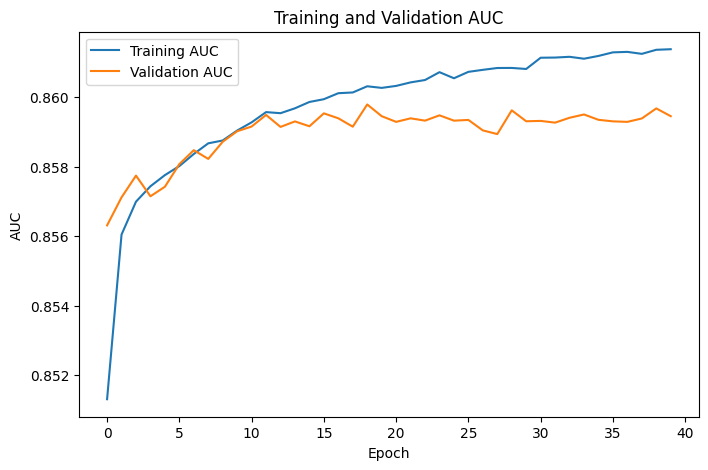

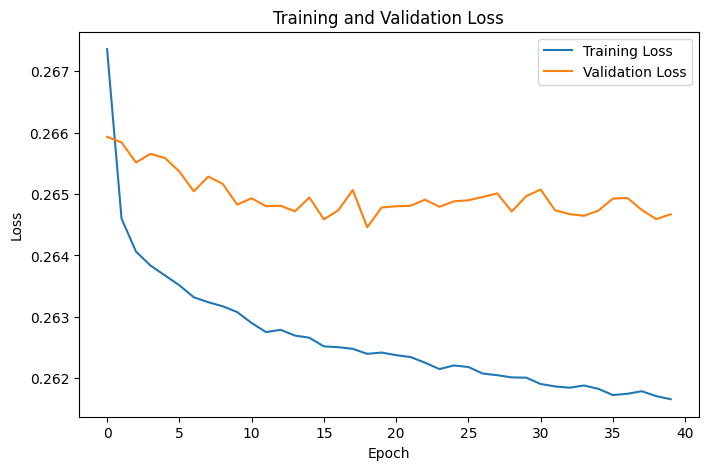

In [22]:
#Learning Curves

# convert the training history to a dataframe
history_df = pd.DataFrame(history.history)


# Plotting the AUC
plt.figure(figsize=(8, 5))
plt.plot(history_df['auc'], label='Training AUC')
plt.plot(history_df['val_auc'], label='Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('Training and Validation AUC')
plt.legend()
plt.show()

# Plotting the Loss
plt.figure(figsize=(8, 5))
plt.plot(history_df['loss'], label='Training Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [38]:
# performing predictions on the test dataset
y_hat = nn_model.predict(x_test)
y_hat = y_hat.flatten().tolist()

5393/5393 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


In [24]:
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_hat)

# Calculate the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)
roc_auc

0.8603508155786985

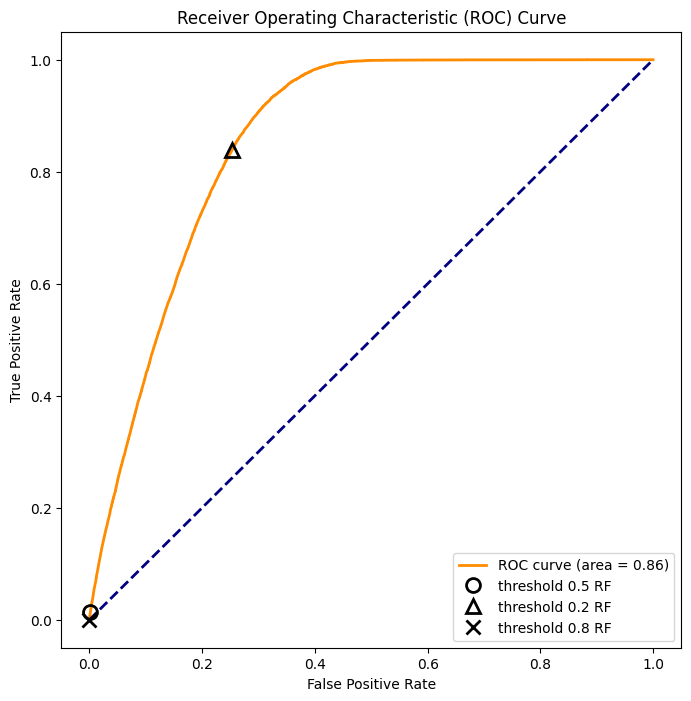

In [25]:
# Plot the ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

close_default_rf = np.argmin(np.abs(thresholds - 0.5))
plt.plot(fpr[close_default_rf], tpr[close_default_rf], 'o', markersize=10,label="threshold 0.5 RF", fillstyle="none", c='k', mew=2)

close_default_rf = np.argmin(np.abs(thresholds - 0.2))
plt.plot(fpr[close_default_rf], tpr[close_default_rf], '^', markersize=10,label="threshold 0.2 RF", fillstyle="none", c='k', mew=2)

close_default_rf = np.argmin(np.abs(thresholds - 0.8))
plt.plot(fpr[close_default_rf], tpr[close_default_rf], 'x', markersize=10,label="threshold 0.8 RF", fillstyle="none", c='k', mew=2)


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [39]:
# when the prediction has to be either 1 or 0, no in between
y_prediction = list(map(round, y_hat))

tp,fp,fn,tn = my_confusion_matrix(y_test,y_prediction)
tp,fp,fn,tn

(292, 256, 21096, 150928)

In [40]:
my_classification_scores(tp,fp,fn,tn)

{'accuracy': 0.8762719328743944,
 'sensitivity': 0.013652515429212643,
 'specificity': 0.9983066991216002,
 'precision': 0.5328467153284672,
 'f1_score': 0.026622902990517873}

## NEW Neural Network 2

In [52]:
#### TESTING NEW ARCHICTECTURES
early_stopping = keras.callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=30, # how many epochs to wait before stopping
    restore_best_weights=True,
)

# Initialize the model
nn_model = Sequential()

# Add layers
nn_model.add(Input(shape=(18,)))  # Input layer
nn_model.add(BatchNormalization())
nn_model.add(Dense(512, activation='relu'))
nn_model.add(Dropout(0.1))
nn_model.add(Dense(128, activation='relu'))
nn_model.add(Dense(1, activation='sigmoid'))  # Output layer

#nn_model.add(Input(shape=(18,)))  # Input layer
#nn_model.add(BatchNormalization())
#nn_model.add(Dense(256, activation='relu'))
#nn_model.add(Dropout(0.2))
#nn_model.add(Dense(128, activation='relu'))
#nn_model.add(Dense(1, activation='sigmoid'))  # Output layer

# Compile the model with binary_crossentropy loss and AUC as a metric
nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[AUC(name='auc')])

history = nn_model.fit(
    x_train, y_train,
    validation_data=(x_validation, y_validation),
    batch_size=1024,
    epochs=200,
    callbacks=[early_stopping]
)

Epoch 1/200
787/787 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - auc: 0.8270 - loss: 0.2839 - val_auc: 0.8565 - val_loss: 0.2666
Epoch 2/200
787/787 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - auc: 0.8548 - loss: 0.2653 - val_auc: 0.8569 - val_loss: 0.2658
Epoch 3/200
787/787 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - auc: 0.8573 - loss: 0.2639 - val_auc: 0.8575 - val_loss: 0.2655
Epoch 4/200
787/787 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - auc: 0.8574 - loss: 0.2640 - val_auc: 0.8576 - val_loss: 0.2655
Epoch 5/200
787/787 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - auc: 0.8583 - loss: 0.2634 - val_auc: 0.8583 - val_loss: 0.2652
Epoch 6/200
787/787 ━━━━━━━━━━━━━━━━━━━━ 18s 22ms/step - auc: 0.8585 - loss: 0.2635 - val_auc: 0.8580 - val_loss: 0.2653
Epoch 7/200
787/787 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - auc: 0.8583 - loss: 0.2631 - val_auc: 0.8582 - val_loss: 0.2653
Epoch 8/200
787/787 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - auc: 0.8593 - loss: 0.2624 - val_auc: 0.8583 - val_loss: 0.2652
Epoch 9/200
787/787 ━━━━━━━━━━━━

In [53]:
nn_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ batch_normalization_4                │ (None, 18)                  │              72 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 512)                 │           9,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 226,709 (885.59 KB)

 Trainable params: 75,557 (295.14 KB)

 Non-trainable params: 36 (144.00 B)

 Optimizer params: 151,116 (590.30 KB)

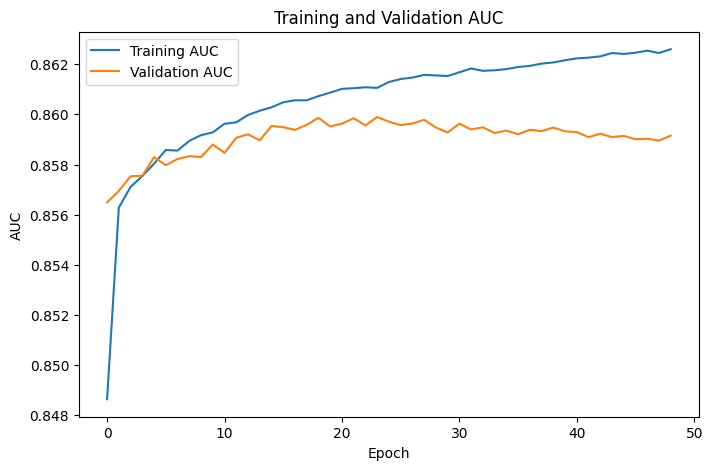

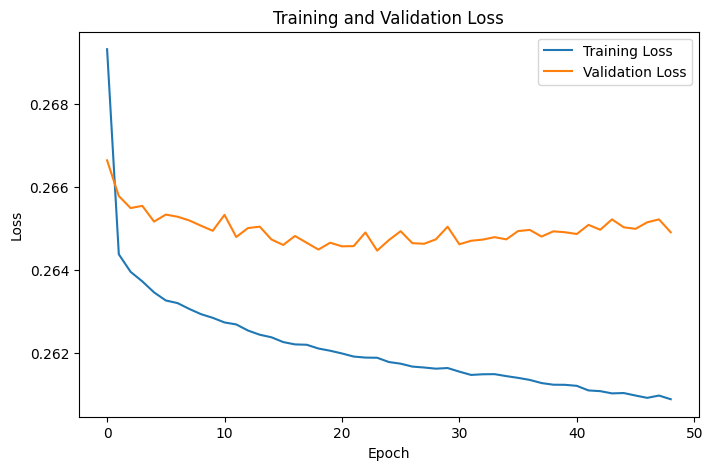

In [54]:
#Learning Curves

# convert the training history to a dataframe
history_df = pd.DataFrame(history.history)


# Plotting the AUC
plt.figure(figsize=(8, 5))
plt.plot(history_df['auc'], label='Training AUC')
plt.plot(history_df['val_auc'], label='Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('Training and Validation AUC')
plt.legend()
plt.show()

# Plotting the Loss
plt.figure(figsize=(8, 5))
plt.plot(history_df['loss'], label='Training Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [55]:
# performing predictions on the test dataset
y_hat = nn_model.predict(x_test)
y_hat = y_hat.flatten().tolist()

5393/5393 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


In [56]:
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_hat)

# Calculate the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)
roc_auc

0.8611422429753062

## Decision Tree

In [15]:
#training of the decision tree takes to long for my computer, will work with a sample
sample_df = insurance_train_df.sample(frac=0.1, random_state=42).reset_index(drop=True)
train_df, validation_df, test_df = my_dataframe_split(sample_df,0.7,0.15,0.15)

In [26]:
x_train = train_df[explanatory_variables]
y_train = train_df['response']

x_validation = validation_df[explanatory_variables]
y_validation = validation_df['response']

x_test = test_df[explanatory_variables]
y_test = test_df['response']

### Grid Search

In [29]:
# Grid Search procedure to find a good parameter selection
parameter_1_LIST = ["squared_error", "friedman_mse","poisson"]
parameter_2_LIST = [None, 3,5,10]

for parameter_1 in parameter_1_LIST:
                for parameter_2 in parameter_2_LIST:
                    # Model training
                    dt_model = DecisionTreeRegressor(random_state=0,criterion=parameter_1,max_depth=parameter_2)
                    dt_model.fit(x_train, y_train)

                    # Model validation
                    y_hat = dt_model.predict(x_validation)
                    # Calculate the ROC curve
                    fpr, tpr, thresholds = roc_curve(y_validation, y_hat)
                    
                    # Calculate the area under the ROC curve (AUC)
                    roc_auc = auc(fpr, tpr)
                    roc_auc

                    print("Decision Tree parameters:", parameter_1," ",parameter_2)
                    print("ROC AUC:", roc_auc)
                    print("\n")
                    


Decision Tree parameters: squared_error   None
ROC AUC: 0.6155703126230233


Decision Tree parameters: squared_error   3
ROC AUC: 0.8309631087004044


Decision Tree parameters: squared_error   5
ROC AUC: 0.8428006284236863


Decision Tree parameters: squared_error   10
ROC AUC: 0.8550396702471161


Decision Tree parameters: friedman_mse   None
ROC AUC: 0.6160168353659434


Decision Tree parameters: friedman_mse   3
ROC AUC: 0.8309631087004044


Decision Tree parameters: friedman_mse   5
ROC AUC: 0.8428006284236863


Decision Tree parameters: friedman_mse   10
ROC AUC: 0.8550396702471161


Decision Tree parameters: poisson   None
ROC AUC: 0.8336017455909066


Decision Tree parameters: poisson   3
ROC AUC: 0.8237266640856058


Decision Tree parameters: poisson   5
ROC AUC: 0.8413049298980116


Decision Tree parameters: poisson   10
ROC AUC: 0.8555592316389777




### Decision Tree with the selected parameter values

In [30]:
# Decision Tree
# squared_error, friedman_mse, absolute_error, poisson
parameter_1 = "poisson"
parameter_2 = 10

dt_model = DecisionTreeRegressor(random_state=0,criterion=parameter_1,max_depth=parameter_2)
dt_model.fit(x_test, y_test)

DecisionTreeRegressor(criterion='poisson', max_depth=10, random_state=0)

In [31]:
# performing predictions on the test dataset
y_hat = dt_model.predict(x_test)
y_hat = y_hat.flatten().tolist()
#y_hat

In [32]:
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_hat)

# Calculate the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)
roc_auc

0.8601897477915819

In [33]:
# Assignin values of either 1 or 0, no in between. This is needed for calculating the metrics of the confusion matrix
y_prediction = list(map(round, y_hat))
tp,fp,fn,tn = my_confusion_matrix(y_test,y_prediction)
print(tp,fp,fn,tn)

89 30 21128 151325


In [34]:
my_classification_scores(tp,fp,fn,tn)

{'accuracy': 0.8773961013374127,
 'sensitivity': 0.00419474949333082,
 'specificity': 0.9998017904925506,
 'precision': 0.7478991596638656,
 'f1_score': 0.008342707161604799}

## Random Forest

In [ ]:
#training of the random forest takes to long for my computer, will work with a sample
sample_df = insurance_train_df.sample(frac=0.1, random_state=42).reset_index(drop=True)
train_df, validation_df, test_df = my_dataframe_split(sample_df,0.7,0.15,0.15)

In [ ]:
x_train = train_df[explanatory_variables]
y_train = train_df['response']

x_validation = validation_df[explanatory_variables]
y_validation = validation_df['response']

x_test = test_df[explanatory_variables]
y_test = test_df['response']

### Random Forest with the selected parameter values

In [47]:
parameter_1 = "poisson"
parameter_2 = 10
parameter_3 =  100

rf_model = RandomForestRegressor(random_state=0,criterion=parameter_1,max_depth=parameter_2,n_estimators=parameter_3)
rf_model.fit(x_train, y_train)

RandomForestRegressor(criterion='poisson', max_depth=10, random_state=0)

In [50]:
# performing predictions on the test dataset
y_hat = rf_model.predict(x_test)
y_hat = y_hat.flatten().tolist()
#y_hat

In [51]:
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_hat)

# Calculate the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)
roc_auc

0.85805795473046

# Submission to competition


## Data loading and preprocessing

In [26]:
# Load the evaluation dataset
insurance_evaluation_path = 'data/test.csv'
insurance_evaluation_raw_df = pd.read_csv(insurance_evaluation_path,index_col=None)
insurance_evaluation_raw_df.columns = insurance_evaluation_raw_df.columns.str.lower()
insurance_evaluation_raw_df.columns = insurance_evaluation_raw_df.columns.str.replace(' ','_')
insurance_evaluation_df = insurance_evaluation_raw_df.copy()

In [27]:
# Data processing

# Vehicle Damage: Map 'Yes' to 1 and 'No' to 0
insurance_evaluation_df['vehicle_damage'] = insurance_evaluation_df['vehicle_damage'].map({'Yes': 1, 'No': 0})

# Gender: Map 'Female' to 1 and 'Male' to 0
insurance_evaluation_df['gender'] = insurance_evaluation_df['gender'].map({'Female': 1, 'Male': 0})

# Vehicle Age: Map '< 1 Year' to 0,'1-2 Year' to 1 and '> 2 Years' to 2
insurance_evaluation_df['vehicle_age'] = insurance_evaluation_df['vehicle_age'].map({'< 1 Year': 0, '1-2 Year': 1,'> 2 Years': 2,})

In [28]:
#Incorporating the calculated region quartiles in the dataframe
insurance_evaluation_df = insurance_evaluation_df.merge(
    region_response_proportion[['region_code', 'region_quartile']], 
    on='region_code', 
    how='left'
)
#Incorporating the calculated channel sextiles in the dataframe
insurance_evaluation_df = insurance_evaluation_df.merge(
    channel_response_proportion[['policy_sales_channel', 'channel_sextile']], 
    on='policy_sales_channel', 
    how='left'
)
# One hot encoding
insurance_evaluation_df = pd.get_dummies(insurance_evaluation_df, columns=['region_quartile', 'channel_sextile'])

# Formating the dummies as 1s and 0s instead of True and False
boolean_columns = insurance_evaluation_df.select_dtypes(include='bool').columns
insurance_evaluation_df[boolean_columns] = insurance_evaluation_df[boolean_columns].astype(int)

#dropping unnecesary columns
insurance_evaluation_df = insurance_evaluation_df.drop(columns=['region_code', 'policy_sales_channel'])


In [29]:
insurance_evaluation_df

,id,gender,age,driving_license,previously_insured,vehicle_age,vehicle_damage,annual_premium,vintage,region_quartile_Q1,region_quartile_Q2,region_quartile_Q3,region_quartile_Q4,channel_sextile_G1,channel_sextile_G2,channel_sextile_G3,channel_sextile_G4,channel_sextile_G5,channel_sextile_G6
0,11504798,1,20,1,0,0,0,2630.0,228,0,1,0,0,1,0,0,0,0,0
1,11504799,0,47,1,0,1,1,37483.0,123,0,0,0,1,0,0,0,0,1,0
2,11504800,0,47,1,0,1,1,2630.0,271,0,1,0,0,0,0,0,0,1,0
3,11504801,1,22,1,1,0,0,24502.0,115,0,1,0,0,1,0,0,0,0,0
4,11504802,0,51,1,0,1,0,34115.0,148,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7669861,19174659,0,57,1,0,1,1,51661.0,109,0,0,0,1,0,0,0,0,1,0
7669862,19174660,0,28,1,1,0,0,25651.0,184,1,0,0,0,1,0,0,0,0,0
7669863,19174661,0,47,1,1,1,0,2630.0,63,0,0,1,0,0,0,0,1,0,0
7669864,19174662,0,30,1,0,0,1,38866.0,119,0,0,0,1,0,0,0,0,1,0


In [30]:
x_evaluation = insurance_evaluation_df[explanatory_variables]

## Model prediction with evaluation data

In [31]:
#y_hat = log_reg.predict(x_evaluation) 
#y_hat = df_model.predict(x_evaluation)  
#y_hat = rf_model.predict(x_evaluation) 
y_hat = nn_model.predict(x_evaluation)  

239684/239684 ━━━━━━━━━━━━━━━━━━━━ 323s 1ms/step


In [32]:
y_hat

array([[9.9251531e-03],
       [3.1332922e-01],
       [2.5890848e-01],
       ...,
       [2.2871376e-04],
       [5.1975608e-01],
       [9.1434267e-05]], dtype=float32)

## Results Formatting for Submission

In [33]:
insurance_evaluation_df['Response'] = y_hat

In [34]:
insurance_evaluation_df

,id,gender,age,driving_license,previously_insured,vehicle_age,vehicle_damage,annual_premium,vintage,region_quartile_Q1,region_quartile_Q2,region_quartile_Q3,region_quartile_Q4,channel_sextile_G1,channel_sextile_G2,channel_sextile_G3,channel_sextile_G4,channel_sextile_G5,channel_sextile_G6,Response
0,11504798,1,20,1,0,0,0,2630.0,228,0,1,0,0,1,0,0,0,0,0,0.009925
1,11504799,0,47,1,0,1,1,37483.0,123,0,0,0,1,0,0,0,0,1,0,0.313329
2,11504800,0,47,1,0,1,1,2630.0,271,0,1,0,0,0,0,0,0,1,0,0.258908
3,11504801,1,22,1,1,0,0,24502.0,115,0,1,0,0,1,0,0,0,0,0,0.000045
4,11504802,0,51,1,0,1,0,34115.0,148,0,0,0,1,0,0,0,0,1,0,0.039271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7669861,19174659,0,57,1,0,1,1,51661.0,109,0,0,0,1,0,0,0,0,1,0,0.240279
7669862,19174660,0,28,1,1,0,0,25651.0,184,1,0,0,0,1,0,0,0,0,0,0.000071
7669863,19174661,0,47,1,1,1,0,2630.0,63,0,0,1,0,0,0,0,1,0,0,0.000229
7669864,19174662,0,30,1,0,0,1,38866.0,119,0,0,0,1,0,0,0,0,1,0,0.519756


In [35]:
# Convert Series to DataFrame
submission_columns = ['id','Response']
submission_df =  insurance_evaluation_df[submission_columns]
# Display the DataFrame
print(submission_df)

               id  Response
0        11504798  0.009925
1        11504799  0.313329
2        11504800  0.258908
3        11504801  0.000045
4        11504802  0.039271
...           ...       ...
7669861  19174659  0.240279
7669862  19174660  0.000071
7669863  19174661  0.000229
7669864  19174662  0.519756
7669865  19174663  0.000091

[7669866 rows x 2 columns]


In [36]:
save_path = 'data/nn_submission3.csv'
submission_df.to_csv(save_path,index=False)